In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.applications.inception_v3 import preprocess_input

from keras.preprocessing import image

from keras.models import Model, Sequential
from keras.layers import Input, Dense

import time
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


## State of the art image classifier

<a href="http://www.image-net.org/">ImageNET</a> is an anual object recognition competition containing a databasis of at least one million labeled images. The objective is to design the algorithm that can better predict the labels and sublabels of the images with best accuracy. The winner algorithms of ImageNET are known to be the state-of-the-art of image recognition. 

Keras has a built-in inplementation of several such winning algorithms, which can be used "as is". In this notebook we will implement the algorithm InceptionV3. When applied to the datased of ImageNET 2012, InceptionV3 achieves impressively more than 96% accuracy for 1000 classes. According to this <a href="https://karpathy.github.io/2014/09/02/what-i-learned-from-competing-against-a-convnet-on-imagenet/">blog post</a>, this is more than humans can achieve!

In [2]:
inception_classifier = InceptionV3(include_top=True, weights='imagenet')

In [3]:
inception_classifier.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 149, 149, 32)  896         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 149, 149, 32)  128         convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 147, 147, 32)  9248        batchnormalization_1[0][0]       
___________________________________________________________________________________________

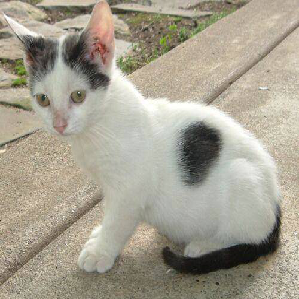

In [4]:
img_path = 'dataset/train/cats/cat.3.jpg'
img = image.load_img(img_path, target_size=(299, 299))
img

In [5]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [6]:
prediction = inception_classifier.predict(x)

## Predicting a class

The InceptionV3 network outputs for each image a vector with 1000 entries, each one corresponding to the probability that the image is one of the classes in the original image-net challenge (http://image-net.org/challenges/LSVRC/2014/browse-synsets). Usually the top 4-5 predictions are the most significant for the image.

The function "decode_predictions" converts the probability into "human-friendly" labels.

In [7]:
decode_predictions(prediction, top=4)

[[(u'n02124075', u'Egyptian_cat', 0.1281704),
  (u'n02123045', u'tabby', 0.081755236),
  (u'n02123597', u'Siamese_cat', 0.067702018),
  (u'n03223299', u'doormat', 0.020990394)]]

## How to transform these 1000 classes into a prediction for cats and dogs?

A first idea is to build a classifier on top of the predictions. It receives the 1000-dimensional vector as features and trains a network that can distinguish two classses, cats and dogs. For the sake of this tutorial, this transformation has already been carried out using keras (see the code below for details on how to do this using keras "flow" generators). Since the inception architecture is huge, in a normal computer such feature extraction can take very long.

The "deep features" have been saved in the file /dataset/deep_features.csv and the corresponding classes in /dataset/deep_classes.csv

In [8]:
deep_features_train = np.loadtxt('dataset/deep_features_train.csv', delimiter=',')
deep_classes_train = np.loadtxt('dataset/deep_classes_train.csv', delimiter=',')

In [9]:
linear_model = LogisticRegression()
linear_model.fit(deep_features_train, deep_classes_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Calculating the accuracy of the model in the train set...

In [10]:
deep_features_test = np.loadtxt('dataset/deep_features_test.csv',delimiter=',')
deep_classes_test = np.loadtxt('dataset/deep_classes_test.csv',delimiter=',')

In [11]:
accuracy = 1-np.sum(np.abs(linear_model.predict(deep_features_test)-deep_classes_test))/len(deep_classes_test)
print('Accuracy = %.2f%%'%(accuracy*100))

Accuracy = 97.71%


In [12]:
def predictor(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    probabilities = inception_classifier.predict(x)
    prediction = linear_model.predict_proba(probabilities)
    
    return prediction

## Finally evaluating our state-of-the-art model on random images

In [13]:
test_set = os.listdir('dataset/test/cats') + os.listdir('dataset/test/dogs')

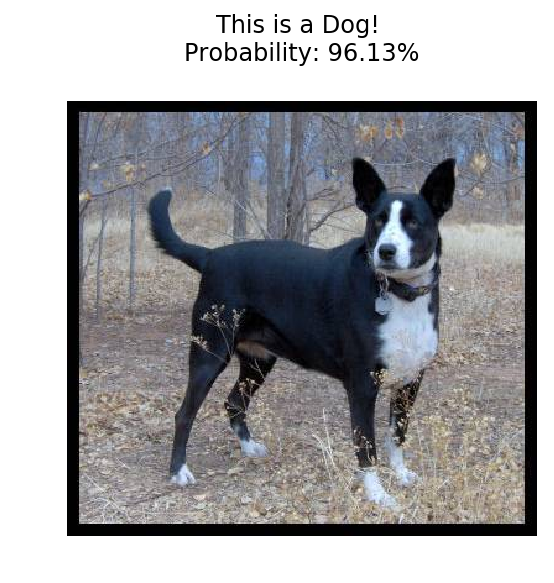

In [14]:
i = np.random.randint(len(test_set))

dic = {0:'Cat',1:'Dog'} 

animal = test_set[i]
if 'cat' in animal:
    img_path = 'dataset/test/cats/'+animal
    test_image = image.load_img(img_path, target_size=(299, 299))
    show_image = cv2.imread(img_path)
elif 'dog' in animal:
    img_path = 'dataset/test/dogs/'+animal
    test_image = image.load_img(img_path, target_size=(299, 299))
    show_image = cv2.imread(img_path)
    
pred = predictor(test_image)[0][0]

show_image = cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB)

plt.title('This is a '+dic[pred<0.5]+'! \nProbability: '+str(round(100*((1-pred)*(pred<0.5)+pred*(pred>0.5)),2))+'%\n')
plt.imshow(show_image);
plt.axis('off');

# .... on the S2DS cat...

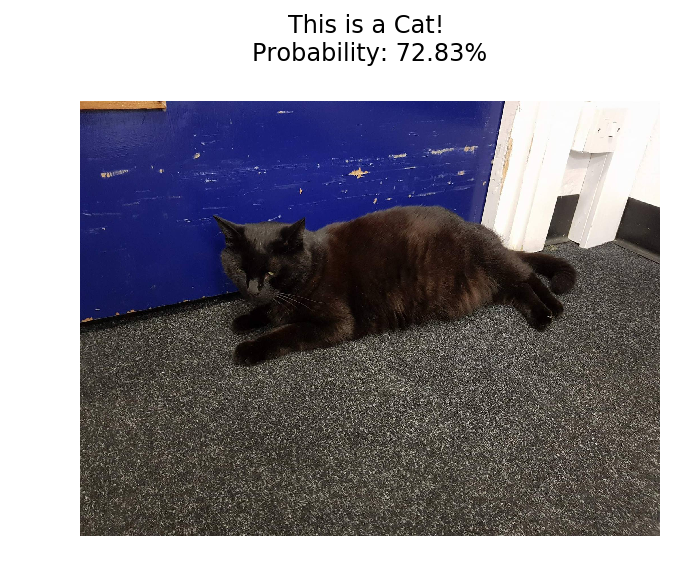

In [15]:
img_path = 'dataset/batman.jpg'
test_image = image.load_img(img_path, target_size=(299, 299))
show_image = cv2.imread(img_path)


pred = predictor(test_image)[0][0]

show_image = cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB)

plt.title('This is a '+dic[pred<0.5]+'! \nProbability: '+str(round(100*((1-pred)*(pred<0.5)+pred*(pred>0.5)),2))+'%\n')
plt.imshow(show_image);
plt.axis('off');

## and on random people!!! :D

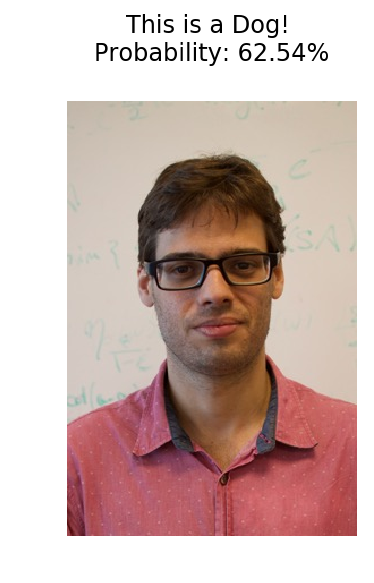

In [24]:
img_path = 'dataset/me.jpg'
test_image = image.load_img(img_path, target_size=(299, 299))
show_image = cv2.imread(img_path)


pred = predictor(test_image)[0][0]

show_image = cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB)

plt.title('This is a '+dic[pred<0.5]+'! \nProbability: '+str(round(100*((1-pred)*(pred<0.5)+pred*(pred>0.5)),2))+'%\n')
plt.imshow(show_image);
plt.axis('off');

## Extracting "deep features". The following piece of code extracts deep features

The following piece of code extracts "deep features". It applies the inception predictor in all instances, extract the vector of probabilities and saves them into a file deep_features.csv. (Since it has to apply the inception predictor in all instances, it could take a couple of hours in a normal computer, or less in a good instance with GPU).

## Bonus:

Can you help me optimise the code below? What would be the right implementation if I were to run it on a powerful Amazon EC2 instance.

In [17]:
# Builds a data flow
data_gen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
data_flow = data_gen.flow_from_directory('dataset/train/', batch_size=32, shuffle=True,
                                         target_size=(299,299), class_mode="binary")

Found 9602 images belonging to 2 classes.


In [18]:
%%time
import sys
batches = 0
# Extract features with batches of size 32

labels = np.zeros(9600)
features = np.zeros([9600, 1000])

start = time.time()
for x_batch, y_batch in data_flow:
    sys.stdout.write('\r'+str(time.time() - start))
    labels[batches*32:(batches+1)*32] = y_batch
    
    features[batches*32:(batches+1)*32] = inception_classifier.predict(x_batch)
    batches+=1
    
    if batches*32 >= 9600:
        break


492.7786760339CPU times: user 4min 45s, sys: 2min 33s, total: 7min 18s
Wall time: 8min 13s


In [19]:
np.savetxt('dataset/deep_features.csv', features, delimiter=',')
np.savetxt('dataset/deep_classes.csv', labels, delimiter=',')

## Correct test labels

In [20]:
data_gen_test = image.ImageDataGenerator(preprocessing_function=preprocess_input)
data_flow_test = data_gen.flow_from_directory('dataset/test/', batch_size=1, shuffle=False,
                                         target_size=(299,299), class_mode="binary")

Found 2400 images belonging to 2 classes.


In [22]:
batches = 0
start = time.time()

labels_test = np.zeros(2402) 
features_test = np.zeros([2402,1000])

start = time.time()

err = 0
for x_batch, y_batch in data_flow_test:
    sys.stdout.write('\r'+str(time.time() - start))
    labels_test[batches] = y_batch
    
    x_probs = inception_classifier.predict(x_batch)
    features_test[batches] = x_probs
    
    err += abs(linear_model.predict(x_probs) - y_batch)
    
    batches+=1
    
    if batches % 100 == 0:
        print(1-err/batches)
    
    if batches >= 2400:
        break

end = time.time()

9.50826406479[ 0.96]
19.0842461586[ 0.97]
28.7154150009[ 0.95666667]
38.2625949383[ 0.95]
47.8268990517[ 0.954]
57.3884990215[ 0.95166667]
66.9483690262[ 0.95142857]
76.6040439606[ 0.95125]
86.1867811681[ 0.94444444]
95.7579441071[ 0.946]
105.306003094[ 0.94272727]
114.867957115[ 0.94416667]
124.409374952[ 0.94769231]
133.987859964[ 0.95071429]
143.568984032[ 0.954]
153.151170015[ 0.955625]
162.747298002[ 0.95823529]
172.301655054[ 0.96055556]
181.854084969[ 0.96263158]
191.408589125[ 0.9645]
200.980293036[ 0.96619048]
210.58197999[ 0.96772727]
220.149804115[ 0.96913043]
229.713392973[ 0.97041667]


In [23]:
np.savetxt('dataset/deep_features_test.csv',features_test,delimiter=',')
np.savetxt('dataset/deep_classes_test.csv',labels_test,delimiter=',')